In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import os, sys
import numpy as np

from rl_envs_forge.envs.grid_world.grid_world import GridWorld
from rl_envs_forge.envs.grid_world.mdp.mdp import GridWorldMDP
from rl_envs_forge.envs.grid_world.grid_world import Action

from src.replay_buffer import ReplayBuffer
from src.policy_iteration import policy_evaluation_v, find_optimal_policy_q
from src.visualize import draw_simple_gridworld

In [51]:
import numpy as np

# Assuming ReplayBuffer and GridWorld classes are already defined
# Initialize the environment
env = GridWorld(
    rows=10,
    cols=10,
    walls=None,
    random_move_frequency=1.0,
    terminal_states={(4, 4): 1.0},
    rewards = {
        "valid_move": 0,
        "wall_collision": 0,
        "out_of_bounds": 0, 
        "default": 0.0,
    }
)

state_dim = 2  # For GridWorld, state can be represented by (row, col) position
action_dim = 1  # Assuming discrete actions
max_size = 1000  # Maximum size of the buffer
n_step = 1  # For simplicity, not using n-step returns here
replay_buffer = ReplayBuffer(max_size, state_dim, action_dim, n_step)

dataset = []

# Simulate episodes
num_episodes = 50
num_steps = 100_000


state = env.reset()
done = False
for _ in range(num_steps):
    # For GridWorld, action can be randomly selected
    action = np.random.choice([0, 1, 2, 3])  # UP, RIGHT, DOWN, LEFT
    next_state, reward, done, _, _ = env.step(action)
    
    # Store the experience in the dataset
    sample = [state, action, reward, next_state, done]
    dataset.append(sample)
    
    if done:
        state = env.reset()
        done = False
        
    state = next_state

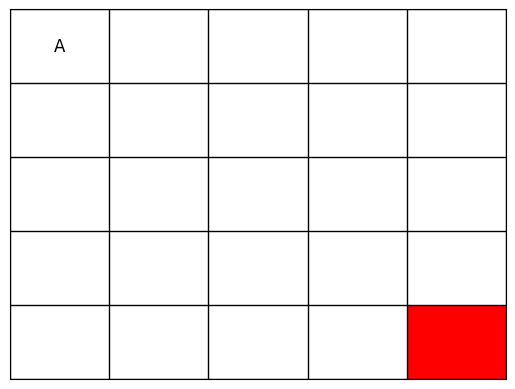

In [60]:
env.render()